##必要なライブラリの読み込み

In [2]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 18.2 MB/s eta 0:00:00


In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import pmdarima as pm
from sklearn.linear_model import LinearRegression
from scipy.stats import t
from scipy.stats import f
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 第8回

# 単回帰分析

In [24]:
x = np.array([1, 2, 3, 4, 5]).reshape(-1, 1)
y = np.array([2, 3, 5, 4, 6])

model = LinearRegression()
model.fit(x, y)
intercept = model.intercept_
coefficient = model.coef_[0]

print(f'単回帰分析の式: Y = {coefficient:.2f} * X + {intercept:.2f}')

単回帰分析の式: Y = 0.90 * X + 1.30


### モデルの妥当性検定を行い、Xの係数に関する検定;t検定を行う

In [28]:
# --- 予測値・残差 ---
y_pred = model.predict(x)
residuals = y - y_pred
n = len(x)

# --- 残差の標準偏差 s ---
s = np.sqrt(np.sum(residuals**2) / (n - 2))

# --- 標準誤差 SE(b1) ---
x_mean = np.mean(x)
se_b1 = s / np.sqrt(np.sum((x - x_mean)**2))

# --- t値の計算 ---
t_value = coefficient / se_b1

# --- tの臨界値 ---
alpha = 0.05
df_deg_free_simple_reg = n - 2 # Rename df to avoid conflict
t_critical = t.ppf(1 - alpha/2, df_deg_free_simple_reg)

# --- 判定 ---
print("【t検定】")
print(f"自由度: {df_deg_free_simple_reg}")
print(f"t値: {t_value:.4f}")
print(f"tの臨界値: ±{t_critical:.4f}")
if abs(t_value) > t_critical:
    print("→ 有意である")
else:
    print("→ 有意でない")

【t検定】
自由度: 3
t値: 3.5762
tの臨界値: ±3.1824
→ 有意である


## 決定係数



In [17]:
r_squared = model.score(x, y)
print(f"決定係数: {r_squared:.3f}")

決定係数: 0.810


# 重回帰分析

# 重回帰モデルの特定

In [31]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

data = {
    "study":  [1,2,3,4,5,6,7,8,9,10],
    "sleep":  [6.5,7,6,7.5,8,6.8,7.2,6,7.8,8.5],
    "score":  [50,55,60,62,70,68,75,72,80,85]
}
df = pd.DataFrame(data)

X = sm.add_constant(df[["study", "sleep"]])
y = df["score"]

# Use statsmodels.api.OLS for consistent and statistically robust results
model_multi_sm = sm.OLS(y, X).fit()

print(f'切片 (Intercept): {model_multi_sm.params["const"]:.2f}')
print(f'study の係数: {model_multi_sm.params["study"]:.2f}')
print(f'sleep の係数: {model_multi_sm.params["sleep"]:.2f}')

切片 (Intercept): 34.20
study の係数: 3.27
sleep の係数: 2.17


## モデル全体の有意検定:F検定

In [33]:
y_multi = df["score"]
n = len(y_multi)
y_pred = model_multi.predict(X)
residuals = y_multi - y_pred

SSR = np.sum((y_pred - np.mean(y_multi))**2)       # 回帰平方和
SSE = np.sum(residuals**2)                   # 残差平方和
df_reg = k                                  # 回帰自由度
df_res = n - k - 1                           # 残差自由度

F_value = (SSR / df_reg) / (SSE / df_res)    # F統計量
p_value_F = 1 - f.cdf(F_value, df_reg, df_res)

print("\n F検定（モデル全体の妥当性）")
print(f"F統計量 = {F_value:.4f}")
print(f"自由度 = ({df_reg}, {df_res})")
print(f"p値 = {p_value_F:.6f}")
if p_value_F < alpha:
    print("→ モデル全体として有意 ")
else:
    print("→ モデル全体として有意でない ")


 F検定（モデル全体の妥当性）
F統計量 = 139.2672
自由度 = (2, 7)
p値 = 0.000002
→ モデル全体として有意 


 ## X1とX2 の係数に関する検定:t検定

In [30]:
# --- モデルをあてはめ ---
y = df["score"] # 重回帰分析用のyを再定義
n = len(y) # 重回帰分析用のnを再定義
k = X.shape[1] - 1 # 重回帰分析の予測子の数 (定数項を除く)

model = sm.OLS(y, X).fit()

# --- 予測値と残差 ---
y_pred = model.predict(X)
residuals = y - y_pred

# --- 残差の標準偏差（標準誤差） s ---
s = np.sqrt(np.sum(residuals**2) / (n - (k + 1)))  # n - p（pは定数項込みのパラメータ数）

# --- 各係数の標準誤差を計算 ---
XtX_inv = np.linalg.inv(np.dot(X.T, X))  # (X'X)^(-1)
se_b = np.sqrt(np.diag(XtX_inv) * s**2)  # 各係数の標準誤差

# --- t値を計算 ---
t_values = model.params / se_b

# --- tの臨界値 ---
alpha = 0.05
df_deg_free_multi_reg = n - (k + 1) # Rename df to avoid conflict
t_critical = t.ppf(1 - alpha/2, df_deg_free_multi_reg)

# --- 結果 ---
print("【Xの係数に関するt検定】")
print(f"自由度: {df_deg_free_multi_reg}")
print(f"tの臨界値: ±{t_critical:.4f}\n")

for name, t_val in zip(model.params.index, t_values):
    result = "有意である" if abs(t_val) > t_critical else "有意でない"
    print(f"{name:>15s} : t = {t_val:>8.4f} → {result}")

【Xの係数に関するt検定】
自由度: 7
tの臨界値: ±2.3646

          const : t =   5.8695 → 有意である
          study : t =  13.3991 → 有意である
          sleep : t =   2.4569 → 有意である


## 決定係数



In [32]:

print(f"重回帰の決定係数: {model.rsquared:.3f}")

重回帰の決定係数: 0.975


# 第9回

次の手順に従って、AR(自己回帰)モデルを構築し、将来値を予測·評価しなさい。

1. ADF検定(Augmented Dickey-Fuller test)\
 データの定常性を確認する。 p値に基づいて判定する(p値<0.05
→定常、p値> 0.05
→非定常)。

2. PACF(偏自己相関関数)による次数(p)の選定
:\
PACFグラフを描き、ARモデルの次数pを決める。 → PACFが有意なラグで急に減衰する箇所を次数候補とする。

3. 最尤推定法(MLE)によるパラメータ推定:\
決定した次数 p を用いてARモデルをあてはめ、ARモデルの係数と誤差分散を推定する。

4. 予測と精度評価 \
最後の5日間を予測し、予測値と実測値を折れ線グラフで重ねて表示する。 予測精度を MAPE(平均絶対パーセント誤差)で評価し、 予測がどの程度正確かを考察する



In [42]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [35]:
values = [
    0.000,1.764,1.642,3.115,5.170,3.652,3.624,2.941,3.495,3.417,
    4.532,3.843,3.827,4.730,4.764,4.381,4.128,2.983,4.352,3.945,
    4.847,5.066,5.616,5.506,4.673,3.602,3.922,6.050,5.815,7.409,
    6.711,6.592,6.445,5.689,6.944,7.094,7.370,7.437,8.176,7.234,
    8.387,8.613,8.207,7.584,7.904,8.202,7.851,9.047,9.273,9.429,
    9.305,9.069,8.306,7.983,9.045,9.578,9.134,10.736,10.335,10.826
]

n = len(values)
dates = pd.date_range(start="2021-01-01", periods=n, freq="D")
series = pd.Series(values, index=dates)

print("データ点数:", len(series))
print(series.head())

データ点数: 60
2021-01-01    0.000
2021-01-02    1.764
2021-01-03    1.642
2021-01-04    3.115
2021-01-05    5.170
Freq: D, dtype: float64


##1. ADF 検定(Augmented Dickey-Fuller test)

In [36]:
adf_res = adfuller(series)
pval = adf_res[1]

print("\n=== ADF 検定 ===")
print("ADF統計量 :", adf_res[0])
print("p値        :", pval)
print("臨界値     :", adf_res[4])
if pval < 0.05:
    print("→ 定常")
else:
    print("→ 非定常（差分を検討）")


=== ADF 検定 ===
ADF統計量 : 0.0426645045361064
p値        : 0.9619213729848419
臨界値     : {'1%': np.float64(-3.560242358792829), '5%': np.float64(-2.9178502070837), '10%': np.float64(-2.5967964150943397)}
→ 非定常（差分を検討）


## 2.  PACF(偏自己相関関数)による次数(p)の選定


=== PACF 結果（先頭10ラグ） ===
Lag 0: 1.000
Lag 1: 0.862
Lag 2: 0.143
Lag 3: -0.081
Lag 4: 0.131
Lag 5: 0.235
Lag 6: 0.025
Lag 7: 0.048
Lag 8: -0.030
Lag 9: -0.004

有意域目安：± 0.258
→ 選んだ次数 p = 1


<Figure size 800x300 with 0 Axes>

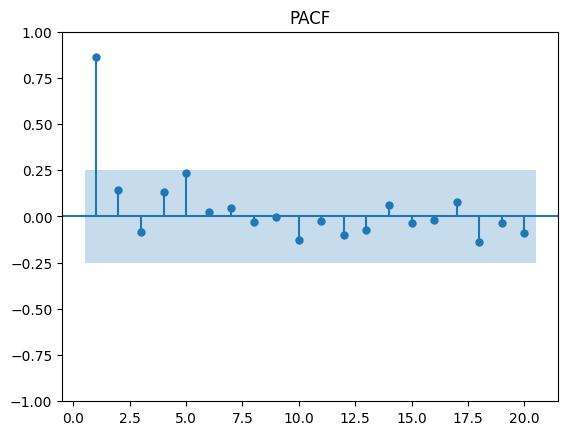

In [51]:
nlags = 20
pacf_vals = pacf(series, nlags=nlags, method='ywmle')

cutoff = 2 / np.sqrt(len(series))
print("\n=== PACF 結果（先頭10ラグ） ===")
for i in range(10):
    print(f"Lag {i}: {pacf_vals[i]:.3f}")

print("\n有意域目安：±", round(cutoff,3))

# 自動 p 選定（簡易ルール）
p = None
for k in range(1, nlags):
    if abs(pacf_vals[k]) > cutoff:
        if k+1 < nlags and abs(pacf_vals[k+1]) < cutoff:
            p = k
            break
if p is None:
    p = 1

print("→ 選んだ次数 p =", p)

plt.figure(figsize=(8,3))
plot_pacf(series, lags=nlags, zero=False)
plt.title("PACF")
plt.show()

## 3. モデル推定（AR(p) = ARIMA(p,0,0)）


In [55]:
train = series.iloc[:-5]
test  = series.iloc[-5:]

print("\n訓練データ:", len(train))
print("テストデータ:", len(test))

model = ARIMA(train, order=(p,0,0))
res = model.fit()

print("\n=== 推定結果 ===")
print(res.summary())

# 推定パラメータ
print("\n推定パラメータ:", res.params)


訓練データ: 55
テストデータ: 5

=== 推定結果 ===
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   55
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 -69.413
Date:                Sun, 30 Nov 2025   AIC                            146.826
Time:                        10:11:58   BIC                            154.856
Sample:                    01-01-2021   HQIC                           149.931
                         - 02-24-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0616      2.955      1.713      0.087      -0.729      10.853
ar.L1          0.8089      0.150      5.394      0.000       0.515       1.103
ar.L2          0.

## 4. 予測

In [56]:
forecast_obj = res.get_forecast(steps=5)
forecast = forecast_obj.predicted_mean
ci = forecast_obj.conf_int()

forecast_df = pd.DataFrame({
    "actual": test.values,
    "forecast": forecast.values,
    "lower": ci.iloc[:,0].values,
    "upper": ci.iloc[:,1].values
}, index=test.index)

print("\n=== 予測結果 ===")
print(forecast_df)


=== 予測結果 ===
            actual  forecast     lower      upper
2021-02-25   9.578  8.765285  7.132560  10.398011
2021-02-26   9.134  8.714098  6.614099  10.814096
2021-02-27  10.736  8.626582  6.136863  11.116302
2021-02-28  10.335  8.547355  5.738888  11.355821
2021-03-01  10.826  8.468842  5.385898  11.551787


## 5. グラフ（実測 vs 予測）

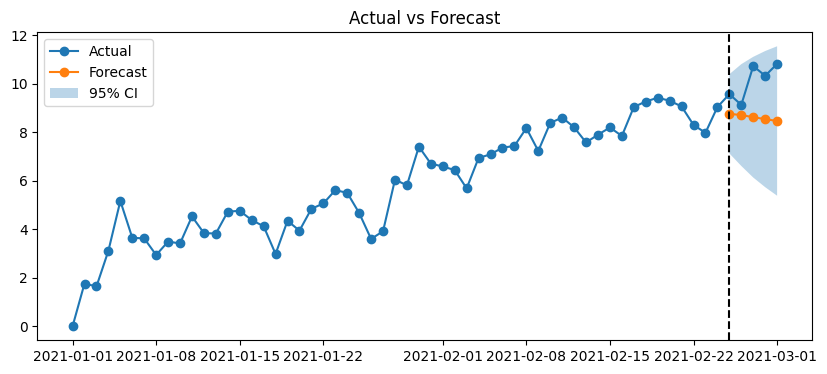

In [57]:
plt.figure(figsize=(10,4))
plt.plot(series.index, series.values, label="Actual", marker="o")
plt.plot(forecast_df.index, forecast_df["forecast"], label="Forecast", marker="o")
plt.fill_between(forecast_df.index, forecast_df["lower"], forecast_df["upper"],
                 alpha=0.3, label="95% CI")
plt.axvline(series.index[-5], linestyle="--", color="black")
plt.legend()
plt.title("Actual vs Forecast")
plt.show()

## 7. MAPE 評価

In [58]:
def mape(a, f):
    a, f = np.array(a), np.array(f)
    return np.mean(np.abs((a - f) / a)) * 100

mape_val = mape(test.values, forecast.values)

print("\n=== MAPE ===")
print("MAPE =", round(mape_val,3), "%")


=== MAPE ===
MAPE = 14.36 %


次の手順に従って、ARIMAモデルを構築し、将来値を予測·評価しなさい。

1. ADF検定(Augmented Dickey-Fuller test)\
データおよびその1次差分系列について、定常性を確認する。\
p値に基づいて定常性を判定する。\
●“p值<0.05→定常”\
●“p値≥0.05→非定常(差分が必要)”

2. 自己相関分析(ACF/PACF)\
ACF·PACFグラフを作成し、ARIMAモデルの次数(p,q)の候補を考察する、

3.  AICによるモデル選択\
AICが最小となる(p,q)を選択し、採用モデルを決定する。\
→AIC値を表にして比較してもよい。

4. 最尤推定法(MLE)によるパラメータ推定\
ARIMAモデルの係数(AR·MA)および誤差分散を推定する。

5. 予測と精度評価\
ARIMAモデルを用いて最後5日間のデータを予測し、
実際データとの誤差を計算する。\ARIMAモデルの全期間出力値と実際データをグラフ
で表示し、その間の誤差を計算する。\誤差計算はMAPE/MAE/RMSEで行う。

In [61]:
values = [
    0.000,1.764,1.642,3.115,5.170,3.652,3.624,2.941,3.495,3.417,
    4.532,3.843,3.827,4.730,4.764,4.381,4.128,2.983,4.352,3.945,
    4.847,5.066,5.616,5.506,4.673,3.602,3.922,6.050,5.815,7.409,
    6.711,6.592,6.445,5.689,6.944,7.094,7.370,7.437,8.176,7.234,
    8.387,8.613,8.207,7.584,7.904,8.202,7.851,9.047,9.273,9.429,
    9.305,9.069,8.306,7.983,9.045,9.578,9.134,10.736,10.335,10.826
]
n = len(values)
dates = pd.date_range(start="2021-01-01", periods=n, freq="D")
series = pd.Series(values, index=dates)
print("データ点数:", n)


データ点数: 60


## ADF検定

In [63]:
print("\n--- ADF検定（元系列） ---")
adf_res = adfuller(series)
adf_stat, adf_pval = adf_res[0], adf_res[1]
print(f"ADF統計量 = {adf_stat:.4f}, p値 = {adf_pval:.4f}")
print("臨界値:", {k:round(v,4) for k,v in adf_res[4].items()})
if adf_pval < 0.05:
    print("判定: p < 0.05 → 定常 と判断（差分不要）")
    d = 0
else:
    print("判定: p >= 0.05 → 非定常（差分が必要）")
    d = 1

# 1次差分を計算
series_diff = series.diff().dropna()
adf_res_diff = adfuller(series_diff)
print("\n--- ADF検定（1次差分） ---")
print(f"ADF統計量 = {adf_res_diff[0]:.4f}, p値 = {adf_res_diff[1]:.4f}")
print("臨界値:", {k:round(v,4) for k,v in adf_res_diff[4].items()})
if adf_res_diff[1] < 0.05:
    print("1次差分は定常である（d=1でモデル化可能）")
else:
    print("1次差分でも非定常の可能性がある")


--- ADF検定（元系列） ---
ADF統計量 = 0.0427, p値 = 0.9619
臨界値: {'1%': np.float64(-3.5602), '5%': np.float64(-2.9179), '10%': np.float64(-2.5968)}
判定: p >= 0.05 → 非定常（差分が必要）

--- ADF検定（1次差分） ---
ADF統計量 = -5.7394, p値 = 0.0000
臨界値: {'1%': np.float64(-3.5602), '5%': np.float64(-2.9179), '10%': np.float64(-2.5968)}
1次差分は定常である（d=1でモデル化可能）



## ACF / PACF の描画

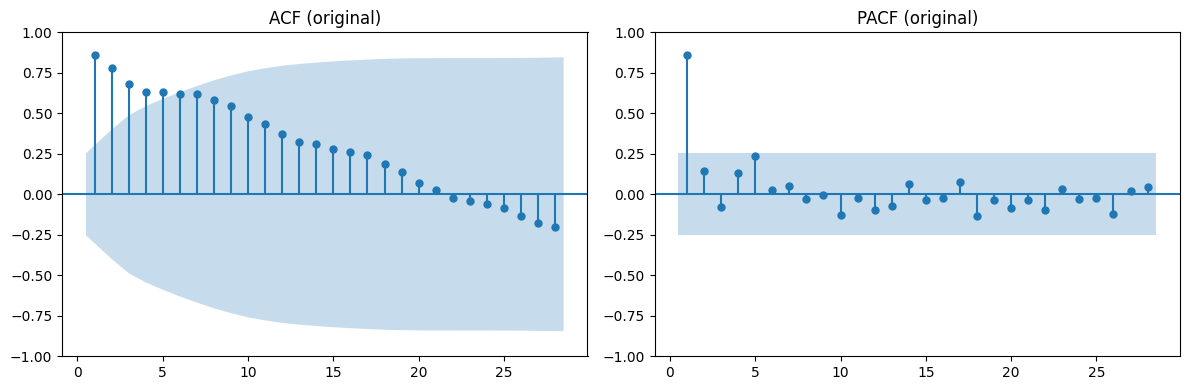

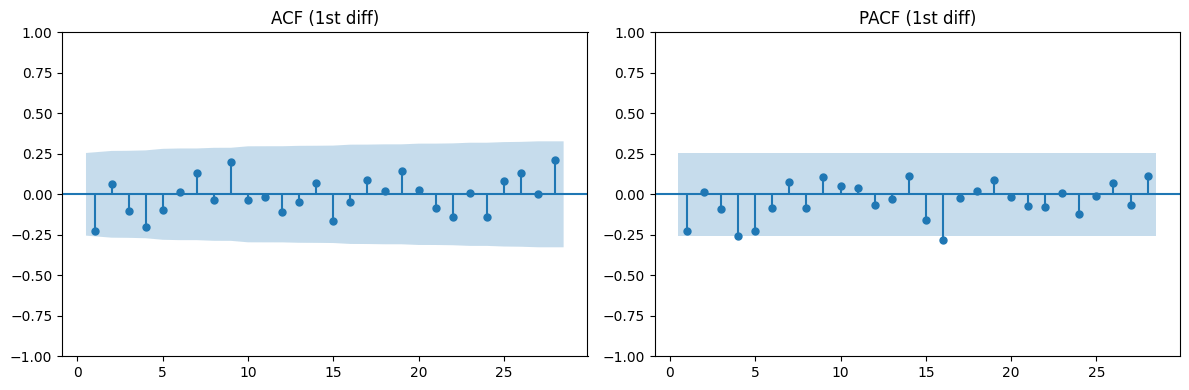

In [66]:
nlags = 28 # Reduced nlags to be less than 29
plt.figure(figsize=(12,4))
plt.subplot(121)
plot_acf(series, lags=nlags, zero=False, ax=plt.gca())
plt.title("ACF (original)")
plt.subplot(122)
# use default PACF method when available
plot_pacf(series, lags=nlags, zero=False, ax=plt.gca(), method='ywm')
plt.title("PACF (original)")
plt.tight_layout()
plt.show()

if d == 1:
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plot_acf(series_diff, lags=nlags, zero=False, ax=plt.gca())
    plt.title("ACF (1st diff)")
    plt.subplot(122)
    plot_pacf(series_diff, lags=nlags, zero=False, ax=plt.gca(), method='ywm')
    plt.title("PACF (1st diff)")
    plt.tight_layout()
    plt.show()

## 3. AICによる (p,q) 選定

In [67]:
max_p = 3
max_q = 3
train = series.iloc[:-5]   # leave last 5 points for forecasting
test  = series.iloc[-5:]

results = []
for p in range(max_p+1):
    for q in range(max_q+1):
        try:
            model = ARIMA(train, order=(p,d,q))
            res = model.fit()
            results.append({"p":p,"d":d,"q":q,"aic":res.aic,"bic":res.bic,"model":res})
        except Exception as e:
            # if fit fails, record NaN
            results.append({"p":p,"d":d,"q":q,"aic":np.nan,"bic":np.nan,"model":None})

res_df = pd.DataFrame(results).sort_values("aic").reset_index(drop=True)
print("\n--- AICによる候補表（上位） ---")
print(res_df[["p","d","q","aic","bic"]].head(10).to_string(index=False))

# Select best by AIC (first non-NaN)
best_row = res_df.dropna(subset=["aic"]).iloc[0]
p_best, d_best, q_best = int(best_row.p), int(best_row.d), int(best_row.q)
best_model = best_row.model
print(f"\n選択モデル: ARIMA({p_best},{d_best},{q_best}) with AIC={best_row.aic:.3f}")


--- AICによる候補表（上位） ---
 p  d  q        aic        bic
 3  1  2 134.076775 146.010679
 3  1  3 136.106948 150.029836
 0  1  0 137.380236 139.369220
 1  1  0 137.825268 141.803236
 0  1  1 137.974974 141.952942
 2  1  3 138.358931 150.292835
 1  1  1 139.611517 145.578469
 2  1  0 139.641114 145.608066
 0  1  2 139.819915 145.786867
 0  1  3 139.957823 147.913759

選択モデル: ARIMA(3,1,2) with AIC=134.077


##4. 最尤推定（MLE）による推定結果


In [69]:
print("\n--- 選択モデルの要約 ---")
print(best_model.summary())

params = best_model.params
sigma2 = best_model.params['sigma2'] # Fix: Access sigma2 from params series
print("\n推定パラメータ:\n", params.round(6))
print("誤差分散 (sigma^2) =", round(sigma2,6))


--- 選択モデルの要約 ---
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   55
Model:                 ARIMA(3, 1, 2)   Log Likelihood                 -61.038
Date:                Sun, 30 Nov 2025   AIC                            134.077
Time:                        11:16:22   BIC                            146.011
Sample:                    01-01-2021   HQIC                           138.679
                         - 02-24-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1582      0.176      6.595      0.000       0.814       1.502
ar.L2         -0.4929      0.255     -1.935      0.053      -0.992       0.006
ar.L3         -0.3217      0.165  

## 5 予測（最後5日）と評価（MAPE/MAE/RMSE）

In [74]:
steps = len(test)
fc_obj = best_model.get_forecast(steps=steps)
fc_mean = fc_obj.predicted_mean
fc_ci = fc_obj.conf_int(alpha=0.05)

forecast_df = pd.DataFrame({
    "actual": test.values,
    "forecast": fc_mean.values,
    "lower": fc_ci.iloc[:,0].values,
    "upper": fc_ci.iloc[:,1].values
}, index=test.index)

print("\n--- 最後5日予測結果 ---")
print(forecast_df.round(4))

# Error metrics for last 5 days
actual = forecast_df["actual"].values
pred = forecast_df["forecast"].values
mape = np.mean(np.abs((actual - pred) / (actual + 1e-8))) * 100
mae = mean_absolute_error(actual, pred)
rmse = np.sqrt(mean_squared_error(actual, pred)) # Fix: Removed squared=False and added np.sqrt()

print("\n=== 予測精度（最後5日） ===")
print(f"MAPE = {mape:.4f} %")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")

# In-sample fitted vs actual (full period)
fitted = best_model.predict(start=series.index[0], end=series.index[-1])
fitted_aligned = fitted.reindex(series.index)
mask = ~np.isnan(fitted_aligned.values)
actual_full = series[mask].values
pred_full = fitted_aligned[mask].values

mape_full = np.mean(np.abs((actual_full - pred_full) / (actual_full + 1e-8))) * 100
mae_full = mean_absolute_error(actual_full, pred_full)
rmse_full = np.sqrt(mean_squared_error(actual_full, pred_full)) # Fix: Removed squared=False and added np.sqrt()

print("\n=== 全期間適合精度 ===")
print(f"MAPE_full = {mape_full:.4f} %")
print(f"MAE_full  = {mae_full:.4f}")
print(f"RMSE_full = {rmse_full:.4f}")


--- 最後5日予測結果 ---
            actual  forecast   lower    upper
2021-02-25   9.578    9.3458  7.9249  10.7667
2021-02-26   9.134    9.7225  8.0668  11.3783
2021-02-27  10.736    9.6689  7.8024  11.5355
2021-02-28  10.335    9.3244  7.3317  11.3172
2021-03-01  10.826    8.8306  6.7233  10.9380

=== 予測精度（最後5日） ===
MAPE = 9.4032 %
MAE  = 0.9787
RMSE = 1.1438

=== 全期間適合精度 ===
MAPE_full = 12.0689 %
MAE_full  = 0.6084
RMSE_full = 0.8055


## グラフ表示

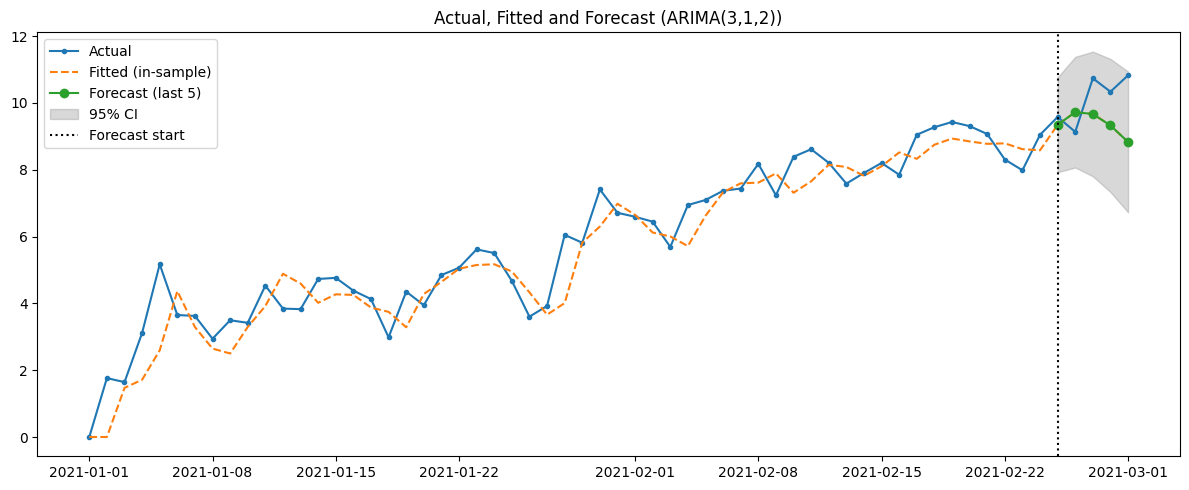

In [75]:
plt.figure(figsize=(12,5))
plt.plot(series.index, series.values, label="Actual", marker='o', markersize=3)
plt.plot(fitted_aligned.index, fitted_aligned.values, label="Fitted (in-sample)", linestyle='--')
plt.plot(forecast_df.index, forecast_df["forecast"].values, label="Forecast (last 5)", marker='o')
plt.fill_between(forecast_df.index, forecast_df["lower"], forecast_df["upper"], color='gray', alpha=0.3, label="95% CI")
plt.axvline(series.index[-5], color='black', linestyle=':', label='Forecast start')
plt.legend()
plt.title(f"Actual, Fitted and Forecast (ARIMA({p_best},{d_best},{q_best}))")
plt.tight_layout()
plt.show()